In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,InceptionV3,ResNet50, MobileNetV2
from keras.applications.vgg16 import preprocess_input
#from keras.applications.mobilenetv2 import preprocess_input
#from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
from PIL import Image

# Train and Test data

In [3]:
train_path = "/Users/harshpanwar/Desktop/Research_Work/COVID/train"
test_path = "/Users/harshpanwar/Desktop/Research_Work/COVID/test"

# Creating Train and Test Data Generators

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
 rotation_range=20,
 featurewise_center = True,
 featurewise_std_normalization = True,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.25,
 zoom_range=0.1,
 zca_whitening = True,
 channel_shift_range = 20,
 horizontal_flip = True ,
 vertical_flip = True ,
 validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

/Users/harshpanwar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [5]:
train_generator = train_datagen.flow_from_directory(train_path,
    target_size = (224, 224),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

Found 200 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


/Users/harshpanwar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/harshpanwar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


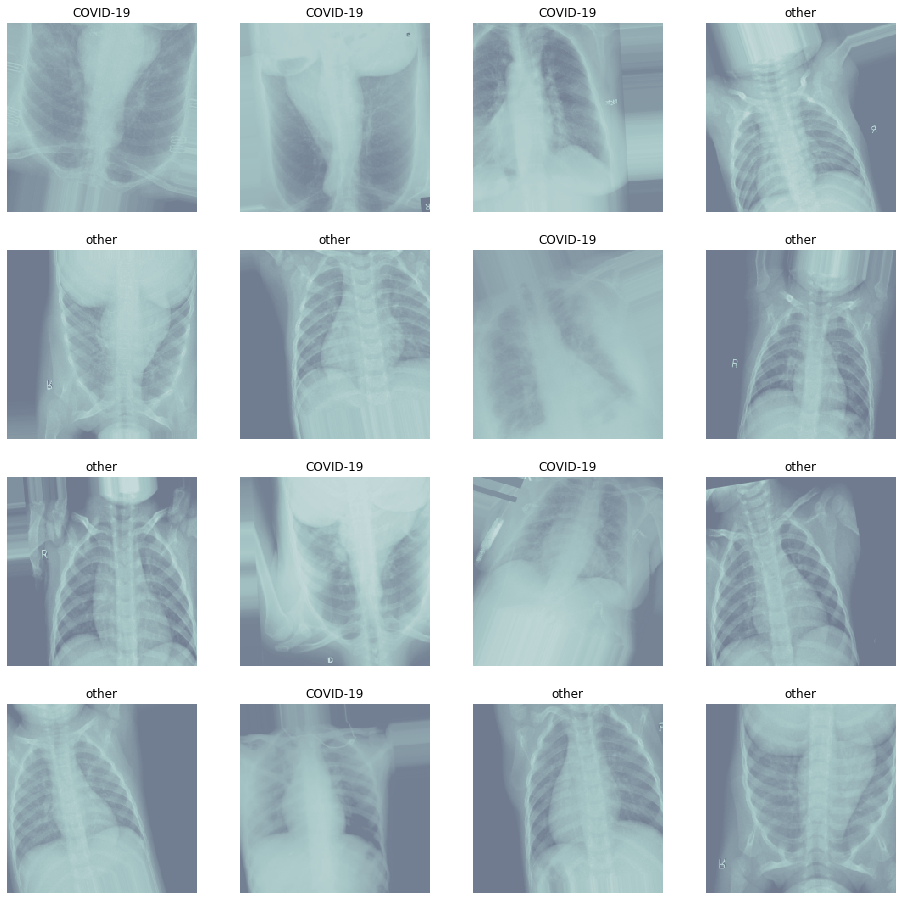

In [6]:
all_labels = ['COVID-19','other']
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Using Transfer learning and loading pretrained model

In [7]:
basemodel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# Adding additional layers and Building the model

In [8]:
headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)#pool_size=(4, 4)
headModel = Flatten(name="flatten")(headModel)
#headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
#headModel = Dense(256, activation="relu")(headModel)
#headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [9]:
model = Model(inputs=basemodel.input, outputs=headModel)

In [10]:
for layer in basemodel.layers:
    layer.trainable = False

# Model parameters, compiling and Training

In [12]:
epochs= 80
lr = 1e-4
BS = 16

In [13]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=lr,decay=lr/epochs),metrics=["accuracy"])

In [14]:
#history = model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=BS),steps_per_epoch=len(X_train) // BS,validation_data=(X_test, Y_test),validation_steps=len(X_test) // BS,epochs=epochs)
H = model.fit_generator(train_generator,
                    steps_per_epoch = 200//BS,
                    epochs = epochs,
                    validation_data = test_generator,
                    validation_steps = 84//BS)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12 steps, validate for 5 steps
Epoch 1/80


/Users/harshpanwar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/harshpanwar/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


12/12 [==============================] - 41s 3s/step - loss: 1.2348 - accuracy: 0.4837 - val_loss: 0.2641 - val_accuracy: 1.0000
Epoch 2/80
12/12 [==============================] - 39s 3s/step - loss: 0.8152 - accuracy: 0.5163 - val_loss: 0.4726 - val_accuracy: 1.0000
Epoch 3/80
12/12 [==============================] - 39s 3s/step - loss: 0.7233 - accuracy: 0.5543 - val_loss: 0.6173 - val_accuracy: 0.6000
Epoch 4/80
12/12 [==============================] - 40s 3s/step - loss: 0.7365 - accuracy: 0.5815 - val_loss: 0.6064 - val_accuracy: 0.6000
Epoch 5/80
12/12 [==============================] - 40s 3s/step - loss: 0.7555 - accuracy: 0.5272 - val_loss: 0.4957 - val_accuracy: 1.0000
Epoch 6/80
12/12 [==============================] - 41s 3s/step - loss: 0.6867 - accuracy: 0.5978 - val_loss: 0.4856 - val_accuracy: 1.0000
Epoch 7/80
12/12 [==============================] - 41s 3s/step - loss: 0.6603 - accuracy: 0.6413 - val_loss: 0.4814 - val_accuracy: 1.0000
Epoch 8/80
12/12 [=============

12/12 [==============================] - 46s 4s/step - loss: 0.2507 - accuracy: 0.9348 - val_loss: 0.0800 - val_accuracy: 1.0000
Epoch 60/80
12/12 [==============================] - 45s 4s/step - loss: 0.2239 - accuracy: 0.9348 - val_loss: 0.0683 - val_accuracy: 1.0000
Epoch 61/80
12/12 [==============================] - 47s 4s/step - loss: 0.2152 - accuracy: 0.9323 - val_loss: 0.0762 - val_accuracy: 1.0000
Epoch 62/80
12/12 [==============================] - 47s 4s/step - loss: 0.1945 - accuracy: 0.9427 - val_loss: 0.0789 - val_accuracy: 1.0000
Epoch 63/80
12/12 [==============================] - 46s 4s/step - loss: 0.2281 - accuracy: 0.9022 - val_loss: 0.0779 - val_accuracy: 1.0000
Epoch 64/80
12/12 [==============================] - 45s 4s/step - loss: 0.2014 - accuracy: 0.9239 - val_loss: 0.0789 - val_accuracy: 1.0000
Epoch 65/80
12/12 [==============================] - 46s 4s/step - loss: 0.1693 - accuracy: 0.9511 - val_loss: 0.0754 - val_accuracy: 1.0000
Epoch 66/80
12/12 [======

# Evaluationg model on Test Data

In [50]:
print("[INFO] saving COVID-19 detector model...")
model.save('/Users/harshpanwar/Desktop/model_res_paper.h5', save_format="h5")

[INFO] saving COVID-19 detector model...


In [16]:
x = model.evaluate_generator(test_generator,
 steps = np.ceil(len(test_generator) // BS),
 use_multiprocessing = False,
 verbose = 1,
 workers=1
 )

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
5/5 [==============================] - 1s 236ms/step - loss: 0.0562 - accuracy: 1.0000


Instructions for updating:
Please use Model.predict, which supports generators.
  84/1000 [=>............................] - ETA: 3:12Predictions finished
prob:[0.9372071 0.0627929]
COVID-19/16654_1_1.png


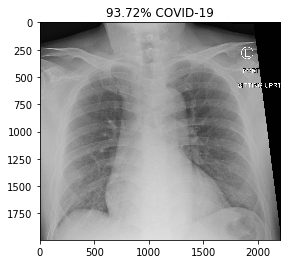

prob:[0.8596936  0.14030646]
COVID-19/16654_2_1.jpg


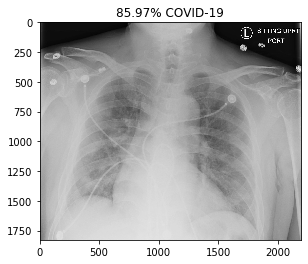

prob:[0.96357596 0.03642408]
COVID-19/16654_4_1.jpg


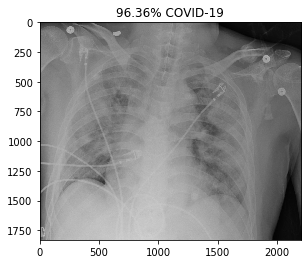

prob:[0.98506606 0.01493396]
COVID-19/16660_1_1.jpg


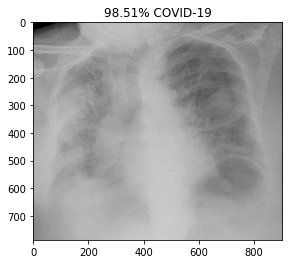

prob:[0.98728895 0.01271109]
COVID-19/16660_2_1.jpg


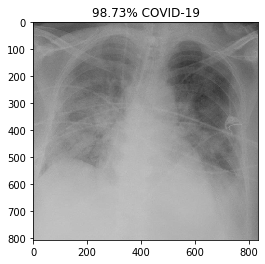

prob:[0.97080964 0.02919029]
COVID-19/16660_3_1.jpg


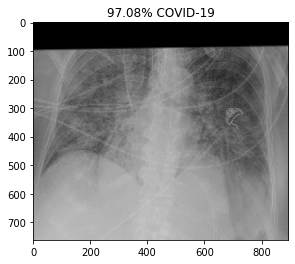

prob:[0.8921266  0.10787336]
COVID-19/16660_4_1.jpg


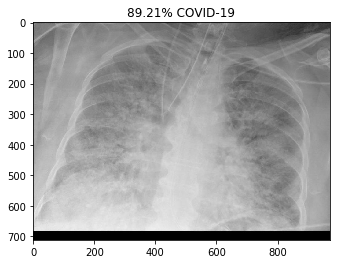

prob:[0.928109   0.07189101]
COVID-19/16663_1_1.jpg


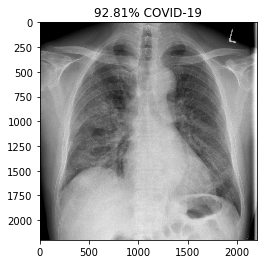

prob:[0.6006619  0.39933816]
COVID-19/16664_1_1.jpg


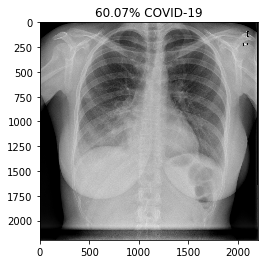

prob:[0.9805884  0.01941167]
COVID-19/16669_1_1.jpeg


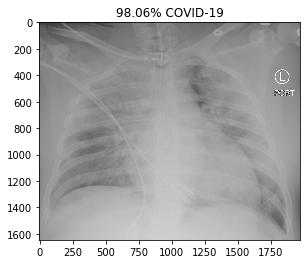

prob:[0.97159123 0.02840873]
COVID-19/16669_3_1.jpeg


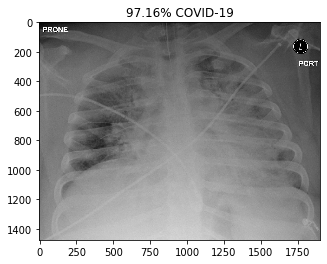

prob:[0.9752181  0.02478188]
COVID-19/16672_1_1.jpg


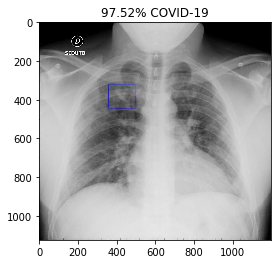

prob:[0.8351052  0.16489482]
COVID-19/2-chest-filmc.jpg


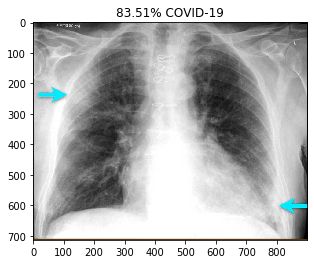

prob:[0.9309433  0.06905669]
COVID-19/4-x-day1.jpg


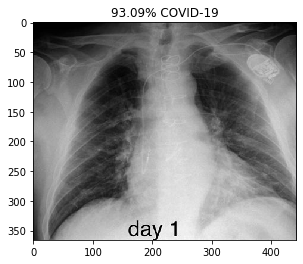

prob:[0.986238   0.01376195]
COVID-19/6b3bdbc31f65230b8cdcc3cef5f8ba8a-40ac-0.jpg


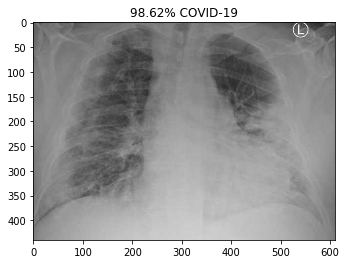

prob:[0.9153709  0.08462915]
COVID-19/7-fatal-covid19.jpg


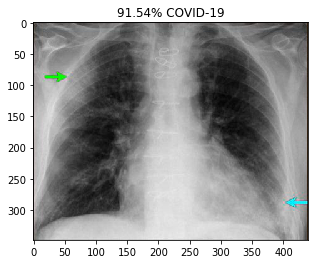

prob:[0.9802578  0.01974226]
COVID-19/88de9d8c39e946abd495b37cd07d89e5-2ee6-0.jpg


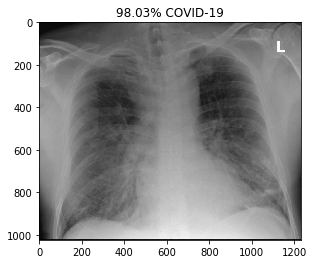

prob:[0.9623698  0.03763016]
COVID-19/88de9d8c39e946abd495b37cd07d89e5-6531-0.jpg


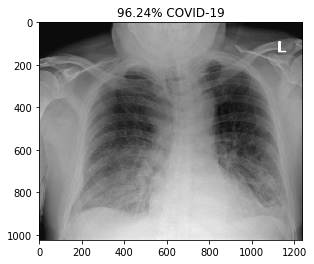

prob:[0.93288517 0.06711484]
COVID-19/AR-1.jpg


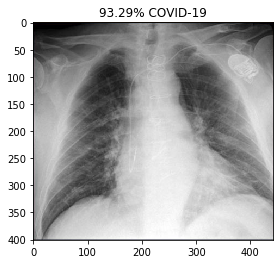

prob:[0.9617796  0.03822042]
COVID-19/AR-2.jpg


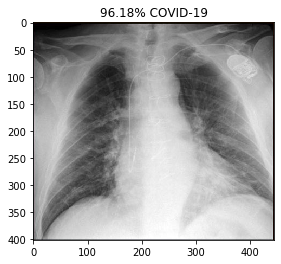

prob:[0.9041853  0.09581475]
COVID-19/ae6c954c0039de4b5edee53865ffee43-e6c8-0.jpg


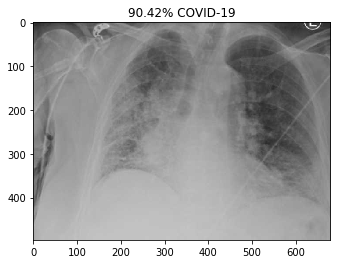

prob:[0.97849107 0.02150894]
COVID-19/covid-19-pneumonia-20.jpg


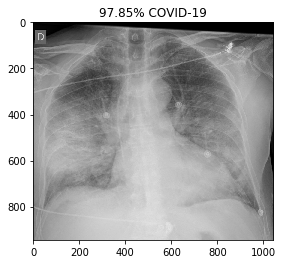

prob:[0.9564042  0.04359575]
COVID-19/covid-19-pneumonia-22-day1-pa.png


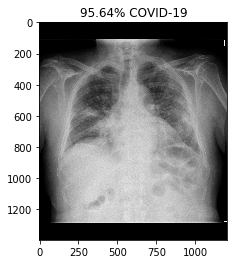

prob:[0.98359436 0.01640566]
COVID-19/covid-19-pneumonia-22-day2-pa.png


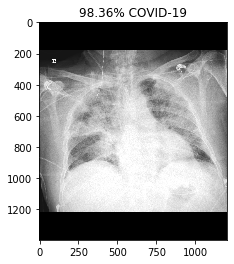

prob:[0.841812   0.15818794]
COVID-19/covid-19-pneumonia-34.png


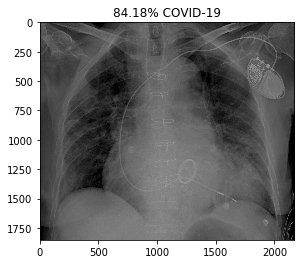

prob:[0.91495645 0.08504356]
COVID-19/covid-19-pneumonia-35-1.jpg


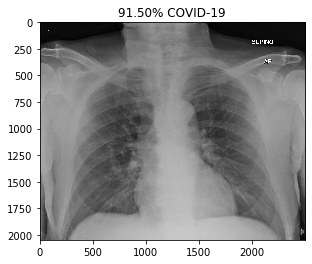

prob:[0.8984562  0.10154381]
COVID-19/covid-19-pneumonia-35-2.jpg


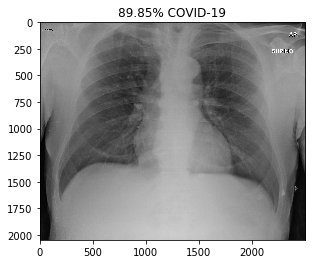

prob:[0.79209524 0.20790474]
COVID-19/covid-19-pneumonia-38-pa.jpg


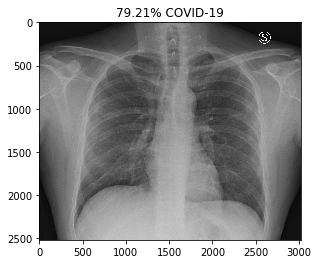

prob:[0.911382   0.08861797]
COVID-19/covid-19-pneumonia-44-day-0.jpeg


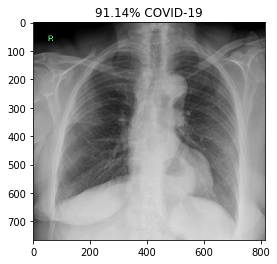

prob:[0.65427643 0.34572348]
COVID-19/covid-19-pneumonia-58-day-10.jpg


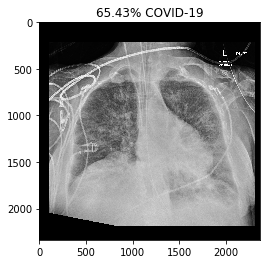

prob:[0.7721723 0.2278277]
COVID-19/covid-19-pneumonia-58-day-3.jpg


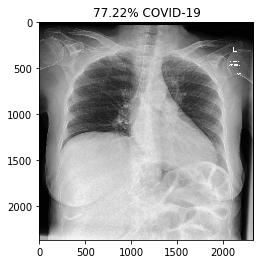

prob:[0.67964196 0.32035807]
COVID-19/covid-19-pneumonia-58-day-7.jpg


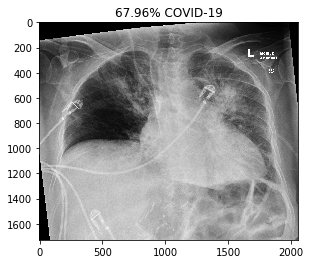

prob:[0.4217604 0.5782396]
COVID-19/covid-19-pneumonia-58-day-9.jpg


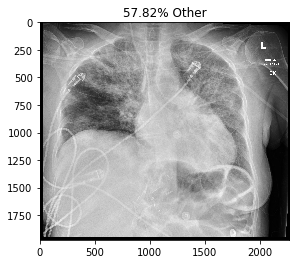

prob:[0.7395745 0.2604255]
COVID-19/covid-19-pneumonia-67.jpeg


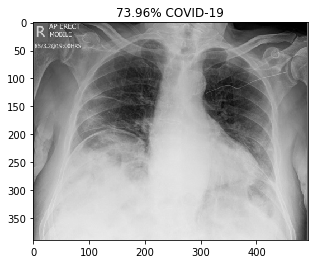

prob:[0.82919896 0.17080103]
COVID-19/covid-19-pneumonia-bilateral.jpg


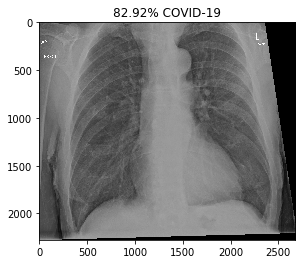

prob:[0.57637984 0.42362013]
COVID-19/covid-19-pneumonia-mild.JPG


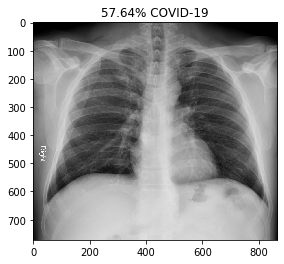

prob:[0.9398029  0.06019717]
COVID-19/extubation-1.jpg


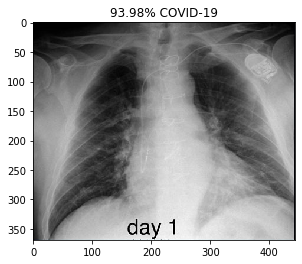

prob:[0.9667281  0.03327195]
COVID-19/extubation-13.jpg


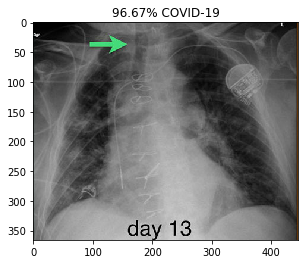

prob:[0.993565   0.00643499]
COVID-19/extubation-4.jpg


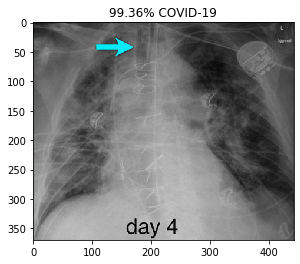

prob:[0.980645   0.01935498]
COVID-19/extubation-8.jpg


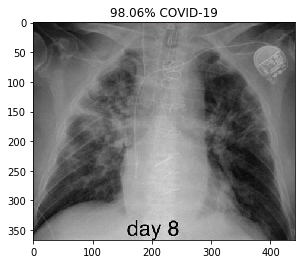

prob:[0.90639657 0.09360341]
COVID-19/paving.jpg


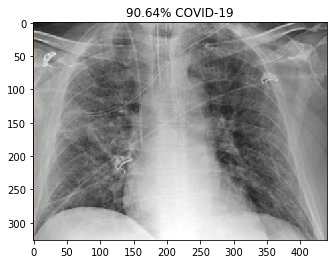

prob:[0.98153245 0.01846759]
COVID-19/yxppt-2020-02-19_00-51-27_287214-day8.jpg


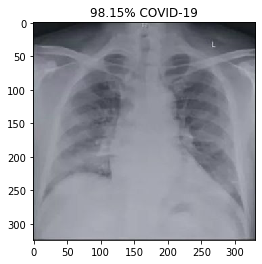

prob:[0.4406521  0.55934787]
other/IM-0001-0001.jpeg


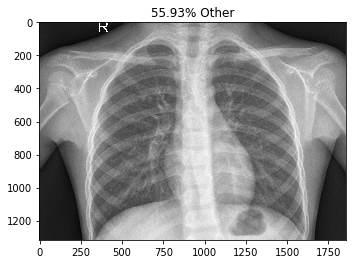

prob:[0.20370442 0.79629564]
other/IM-0003-0001.jpeg


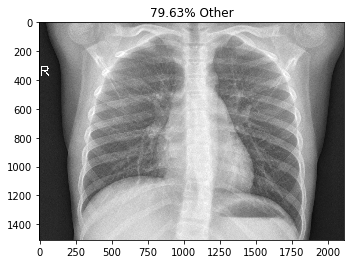

prob:[0.4250731 0.5749269]
other/IM-0005-0001.jpeg


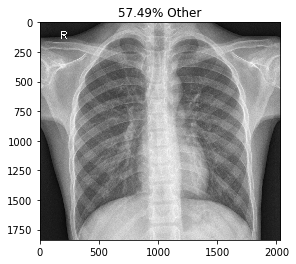

prob:[0.63340336 0.36659664]
other/IM-0006-0001.jpeg


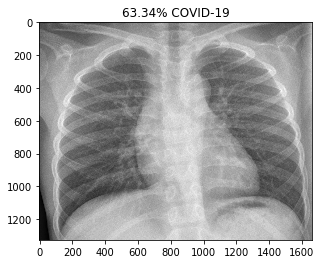

prob:[0.13937473 0.86062527]
other/IM-0007-0001.jpeg


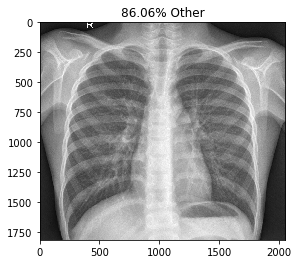

prob:[0.02541539 0.9745846 ]
other/IM-0009-0001.jpeg


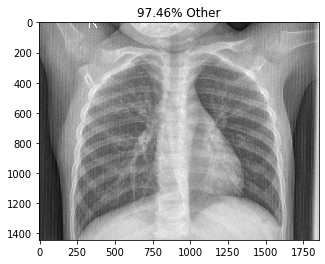

prob:[0.4291473 0.5708527]
other/IM-0010-0001.jpeg


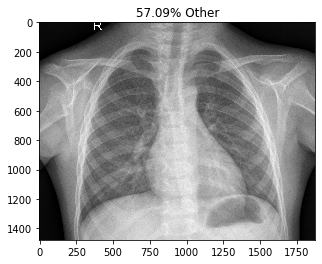

prob:[0.5563673  0.44363275]
other/IM-0011-0001-0001.jpeg


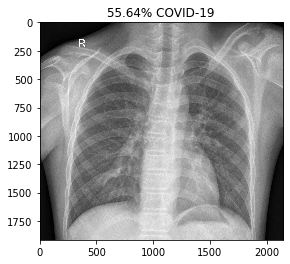

prob:[0.44764364 0.5523564 ]
other/IM-0011-0001-0002.jpeg


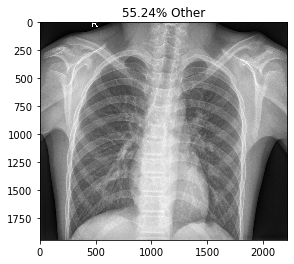

prob:[0.23329505 0.766705  ]
other/IM-0011-0001.jpeg


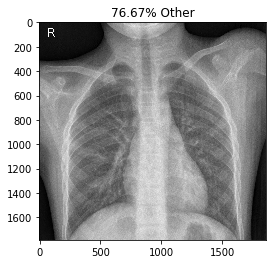

prob:[0.467938   0.53206205]
other/IM-0013-0001.jpeg


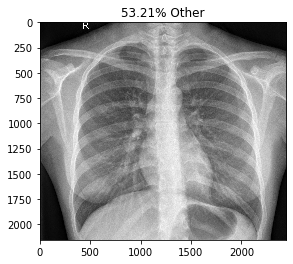

prob:[0.56520426 0.43479577]
other/IM-0015-0001.jpeg


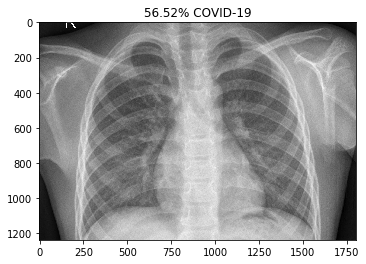

prob:[0.2811925 0.7188075]
other/IM-0016-0001.jpeg


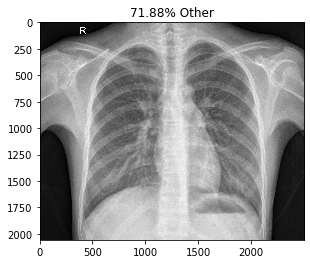

prob:[0.63305306 0.36694697]
other/IM-0017-0001.jpeg


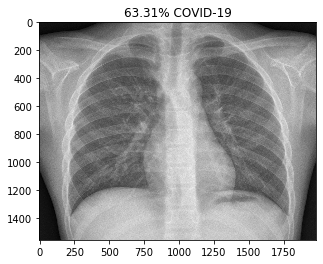

prob:[0.15793994 0.84206   ]
other/IM-0019-0001.jpeg


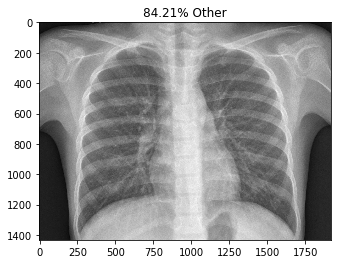

prob:[0.17253636 0.8274636 ]
other/IM-0021-0001.jpeg


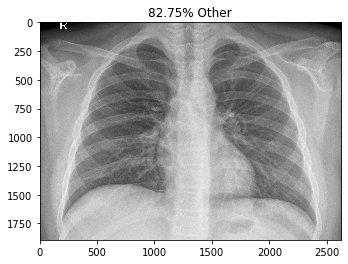

prob:[0.9134919  0.08650813]
other/IM-0022-0001.jpeg


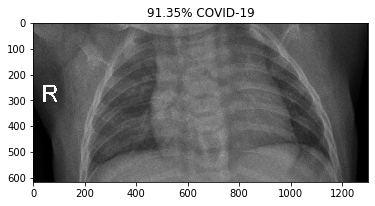

prob:[0.41535366 0.5846463 ]
other/IM-0023-0001.jpeg


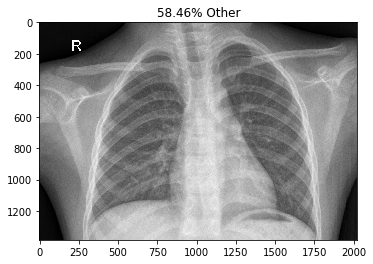

prob:[0.17932978 0.82067025]
other/IM-0025-0001.jpeg


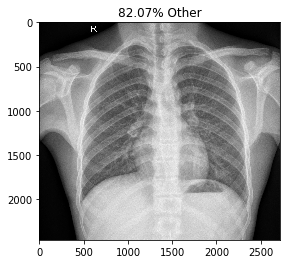

prob:[0.43534425 0.5646557 ]
other/IM-0027-0001.jpeg


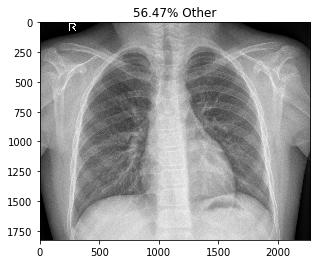

prob:[0.16568086 0.8343191 ]
other/IM-0028-0001.jpeg


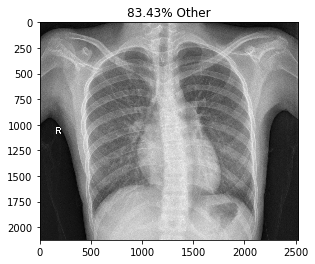

prob:[0.65304106 0.3469589 ]
other/IM-0029-0001.jpeg


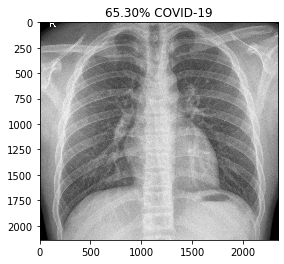

prob:[0.16050783 0.8394922 ]
other/IM-0030-0001.jpeg


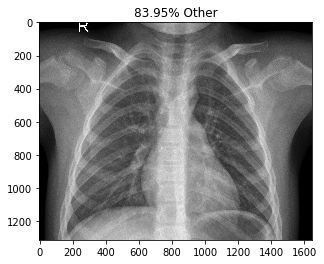

prob:[0.2973176  0.70268244]
other/IM-0031-0001.jpeg


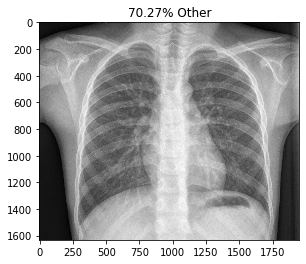

prob:[0.27657464 0.7234253 ]
other/IM-0033-0001-0001.jpeg


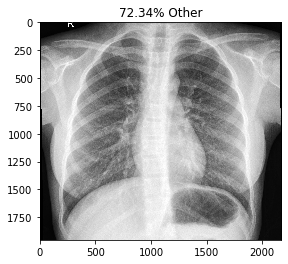

prob:[0.09506534 0.9049347 ]
other/IM-0033-0001-0002.jpeg


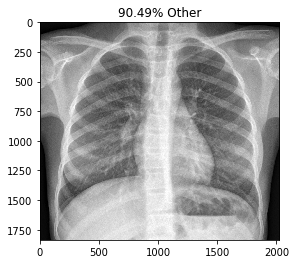

prob:[0.26440072 0.7355993 ]
other/IM-0033-0001.jpeg


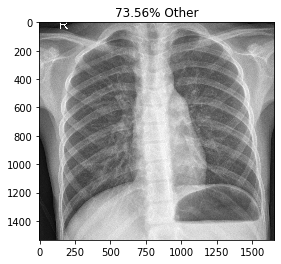

prob:[0.11059684 0.88940316]
other/IM-0035-0001.jpeg


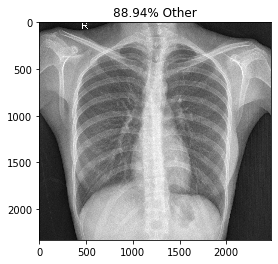

prob:[0.32046583 0.6795341 ]
other/IM-0036-0001.jpeg


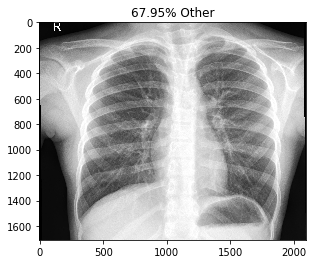

prob:[0.7770984  0.22290154]
other/IM-0037-0001.jpeg


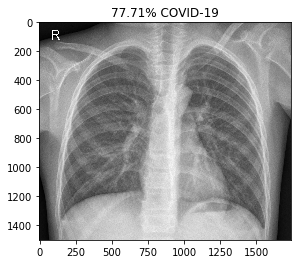

prob:[0.7632026 0.2367974]
other/IM-0039-0001.jpeg


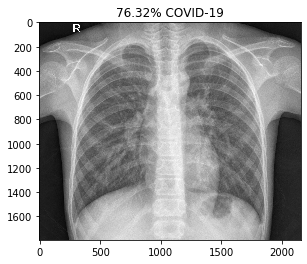

prob:[0.49889514 0.5011049 ]
other/IM-0041-0001.jpeg


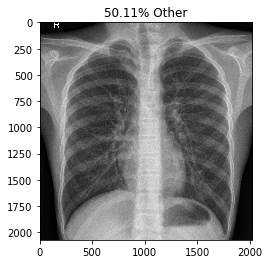

prob:[0.36098066 0.63901925]
other/IM-0043-0001.jpeg


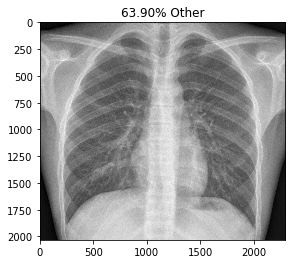

prob:[0.38026732 0.61973274]
other/IM-0045-0001.jpeg


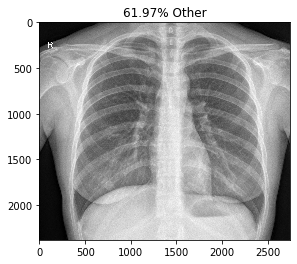

prob:[0.6750595  0.32494053]
other/IM-0046-0001.jpeg


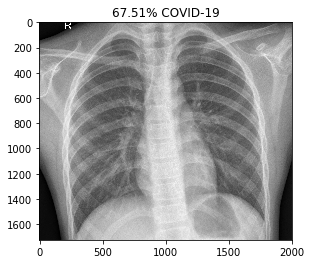

prob:[0.09757554 0.9024245 ]
other/IM-0049-0001.jpeg


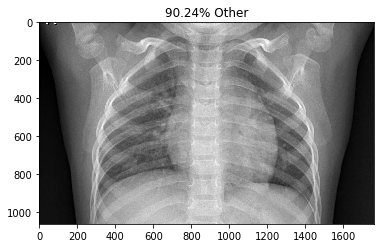

prob:[0.188849   0.81115097]
other/IM-0050-0001.jpeg


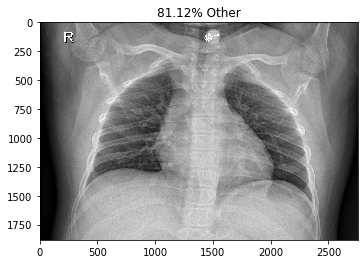

prob:[0.11673958 0.8832604 ]
other/IM-0059-0001.jpeg


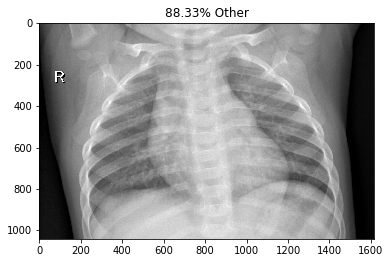

prob:[0.01372112 0.98627895]
other/IM-0061-0001.jpeg


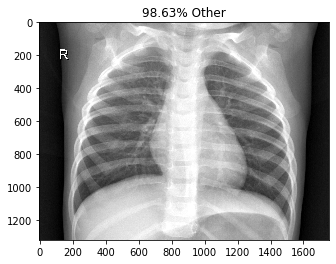

prob:[0.02321935 0.97678065]
other/IM-0063-0001.jpeg


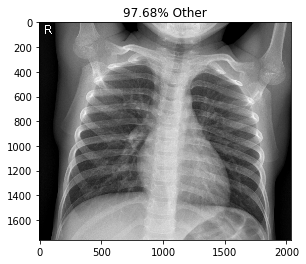

prob:[0.09696075 0.9030393 ]
other/IM-0065-0001.jpeg


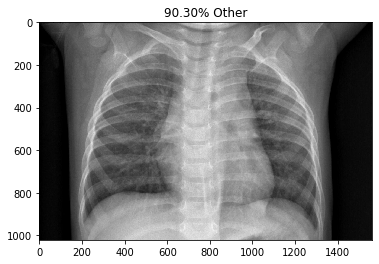

prob:[0.02819253 0.9718075 ]
other/IM-0067-0001.jpeg


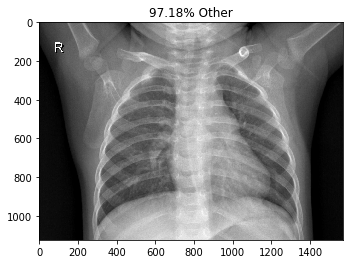

In [17]:
#eval_generator.reset() 
pred = model.predict_generator(test_generator,1000,verbose=1)
print("Predictions finished")
import cv2
import matplotlib.image as mpimg
for index, probability in enumerate(pred):
 image_path = test_path + "/" +test_generator.filenames[index]
 image = mpimg.imread(image_path)
 #BGR TO RGB conversion using CV2
 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 pixels = np.array(image)
 plt.imshow(pixels)
 print("prob:{}".format(probability))
 print(test_generator.filenames[index])
 if probability[1] > 0.5:
     plt.title('%.2f' % (probability[1]*100) + '% Other')
 else:
     plt.title('%.2f' % ((1-probability[1])*100) + '% COVID-19')
 plt.show()

In [18]:
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Test loss: 0.056194663606584074
Test accuracy: 1.0


# Loading the saved model for prediction

In [19]:
# import keras
# from keras.models import load_model
# model_ = tf.keras.models.load_model('/Users/harshpanwar/Desktop/Research_Work/COVID/Covid_Binary.h5')

In [20]:
# image_test = Image.open("/Users/harshpanwar/Desktop/Research_Work/COVID/test/COVID-19/4-x-day1.jpg").convert('RGB')
# image_test = image_test.resize((224,224))
# data_test = np.asarray(image_test)
# img = np.reshape(data_test,[1,224,224,3])

In [21]:
# plt.imshow(image_test)
# model.predict(img).tolist()


In [22]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [23]:
loss, acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=0)

  ...
    to  
  ['...']


In [24]:
loss

0.31745550017027807

In [25]:
acc

0.88095236

In [26]:
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
Y_pred = model.predict_generator(test_generator)

In [27]:
Y_pred

array([[0.9372071 , 0.0627929 ],
       [0.8596936 , 0.14030646],
       [0.96357596, 0.03642408],
       [0.98506606, 0.01493396],
       [0.98728895, 0.01271109],
       [0.97080964, 0.02919029],
       [0.8921266 , 0.10787336],
       [0.928109  , 0.07189101],
       [0.6006619 , 0.39933816],
       [0.9805884 , 0.01941167],
       [0.97159123, 0.02840873],
       [0.9752181 , 0.02478188],
       [0.8351052 , 0.16489482],
       [0.9309433 , 0.06905669],
       [0.986238  , 0.01376195],
       [0.9153709 , 0.08462915],
       [0.9802578 , 0.01974226],
       [0.9623698 , 0.03763016],
       [0.93288517, 0.06711484],
       [0.9617796 , 0.03822042],
       [0.9041853 , 0.09581475],
       [0.97849107, 0.02150894],
       [0.9564042 , 0.04359575],
       [0.98359436, 0.01640566],
       [0.841812  , 0.15818794],
       [0.91495645, 0.08504356],
       [0.8984562 , 0.10154381],
       [0.79209524, 0.20790474],
       [0.911382  , 0.08861797],
       [0.65427643, 0.34572348],
       [0.

In [28]:
y_pred = np.argmax(Y_pred, axis=1)

In [29]:
print(confusion_matrix(test_generator.classes, y_pred))

[[41  1]
 [ 9 33]]


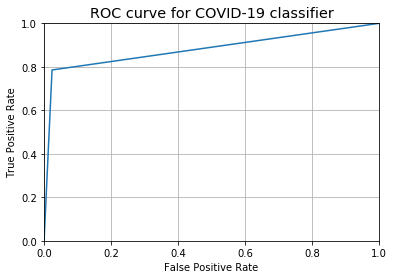

In [30]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_generator.classes, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for COVID-19 classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [49]:
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
auc_keras

0.8809523809523808

Text(0, 0.5, 'Frequency')

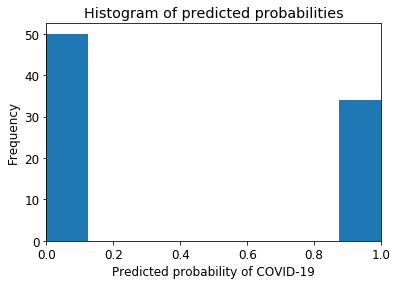

In [31]:
plt.hist(y_pred, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of COVID-19')
plt.ylabel('Frequency')

In [32]:
print('Classification Report')
target_names = ['COVID-19','other']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    COVID-19       0.82      0.98      0.89        42
       other       0.97      0.79      0.87        42

    accuracy                           0.88        84
   macro avg       0.90      0.88      0.88        84
weighted avg       0.90      0.88      0.88        84



In [33]:
import itertools
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [34]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=y_pred)
cm_plot_labels= ['COVID-19','other']

Confusion matrix, without normalization
[[41  1]
 [ 9 33]]


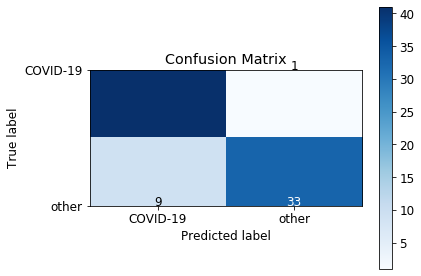

In [35]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [36]:
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


[[41  1]
 [ 9 33]]
acc: 0.8810
sensitivity: 0.9762
specificity: 0.7857


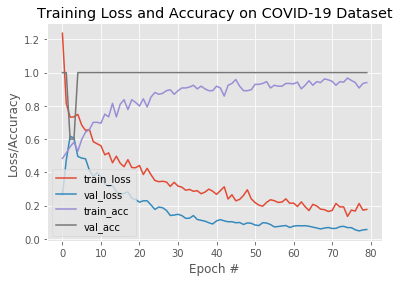

In [38]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

ImportError: cannot import name 'imresize' from 'scipy.misc' (/Users/harshpanwar/opt/anaconda3/lib/python3.7/site-packages/scipy/misc/__init__.py)